In [1]:
import numpy as np
import scipy as scp
import random 
from pyedflib import highlevel
import pyedflib as plib
import matplotlib.pyplot as plt
import mne as mne
from scipy import linalg as la
from sklearn.linear_model import Perceptron
from sklearn.cluster import AffinityPropagation
import os

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import pickle

<h1>Exemplo de handling destes dados

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
# unpickle the data
with open('./Process_Collected/data_segmented.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())

key_order = ["rest", "left", "right", "both", "feet"]

all_data = []
for key in key_order:
    key_data = []
    for band in range(17):
        band_data = []
        for event in range(len(data[key][band])):
            data_event = np.array(data[key][band][event])
            if key == 'rest':
                data_event = data_event[:,100:350]
                if data_event.shape[1] != 250:
                    continue
            band_data.append(np.array(data_event))
        if key == 'rest':
            for i in band_data:
                if i.shape[1] != 250:
                    print(i.shape)
        a = np.array(band_data)
        key_data.append(np.array(band_data))
    print(key)
    key_data = np.array(key_data)
    if key == 'rest':
        random.shuffle(key_data)
        key_data = key_data[:,:150]
    print(key_data.shape)
    all_data.append(key_data)

all_data = np.expand_dims(np.array(all_data), axis=0)
print(all_data.shape)
all_data = all_data.transpose(3, 0, 1, 2, 4, 5)
print(all_data.shape)

all_train_data, all_test_data = train_test_split(all_data, test_size=0.2, random_state=42)

# add new dim
all_train_data = all_train_data.transpose(1, 3, 2, 0, 4, 5)
all_test_data = all_test_data.transpose(1, 3, 2, 0, 4, 5)

print(all_train_data.shape)
print(all_test_data.shape)



dict_keys(['left', 'right', 'both', 'feet', 'rest'])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Sujeito:  1
Banda:  1


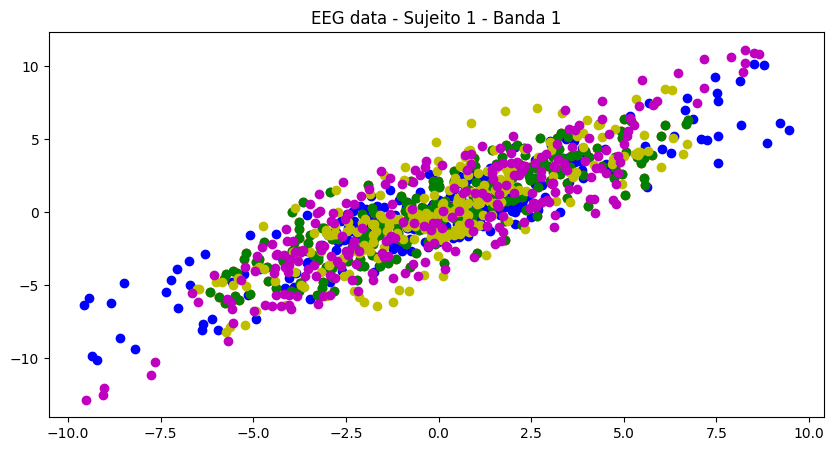

Banda:  2


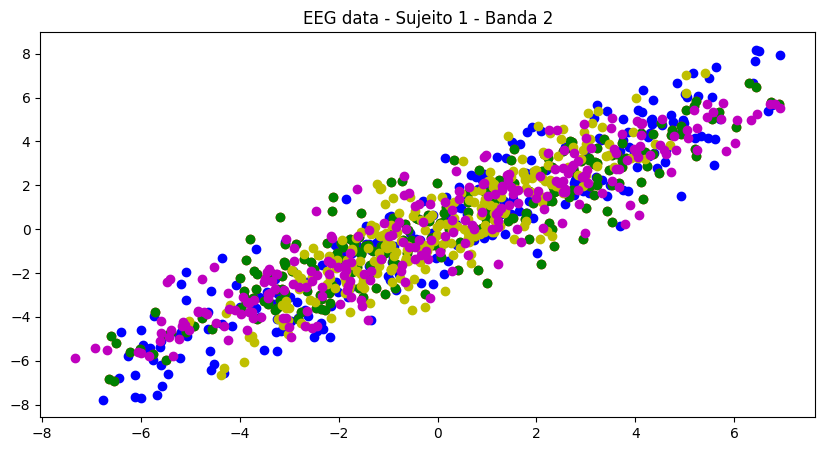

Banda:  3


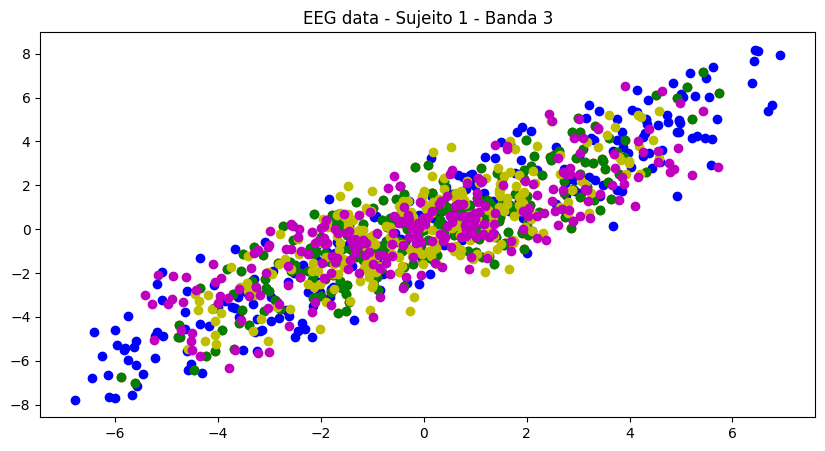

Banda:  4


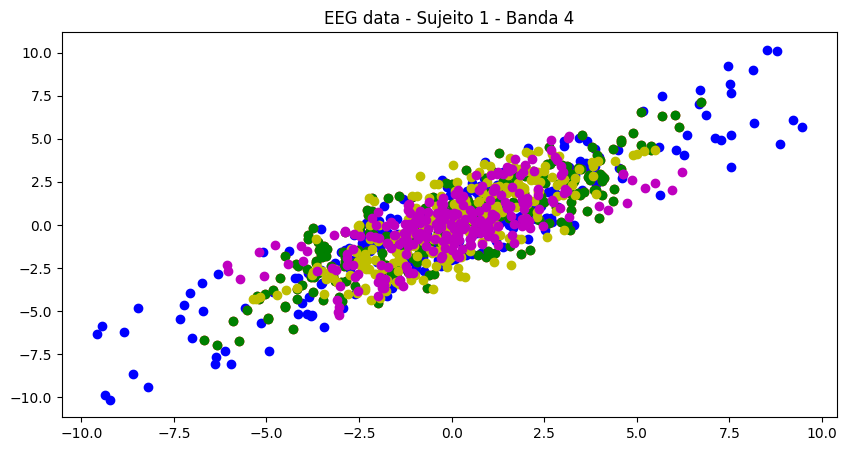

Banda:  5


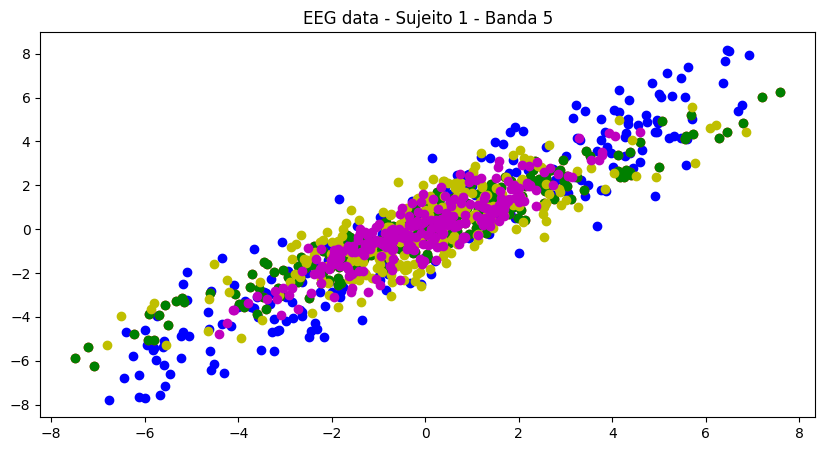

Banda:  6


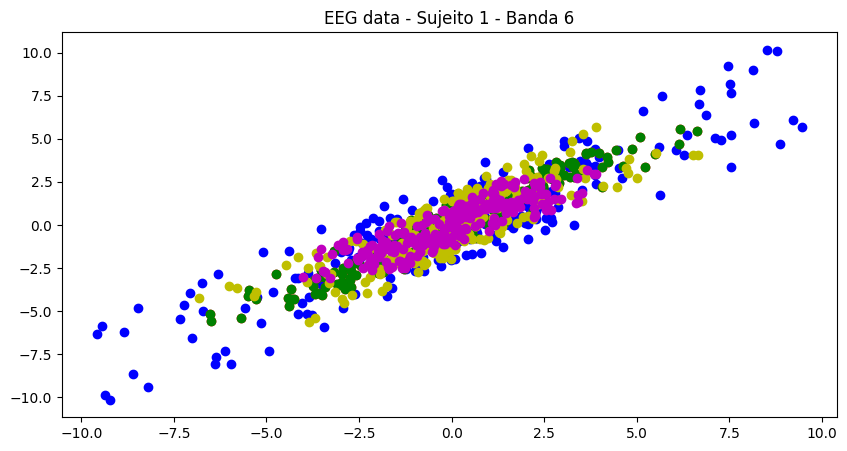

Banda:  7


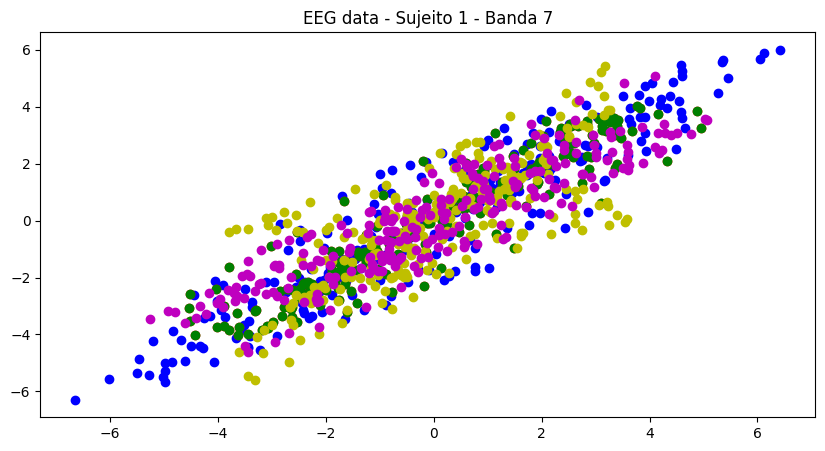

Banda:  8


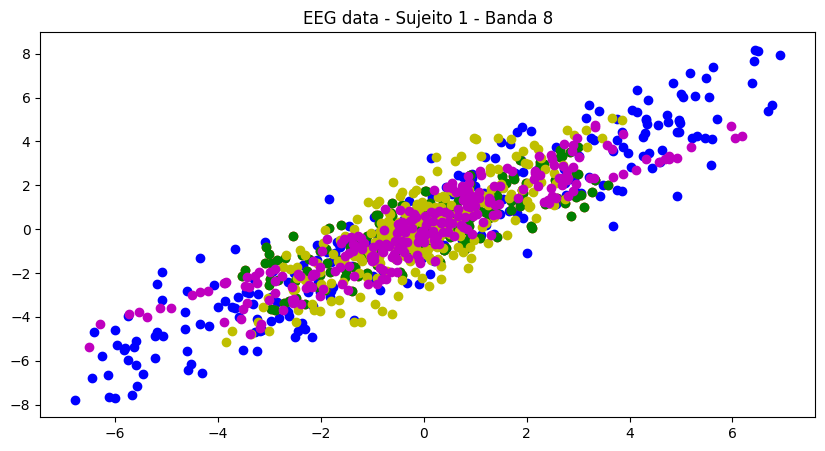

Banda:  9


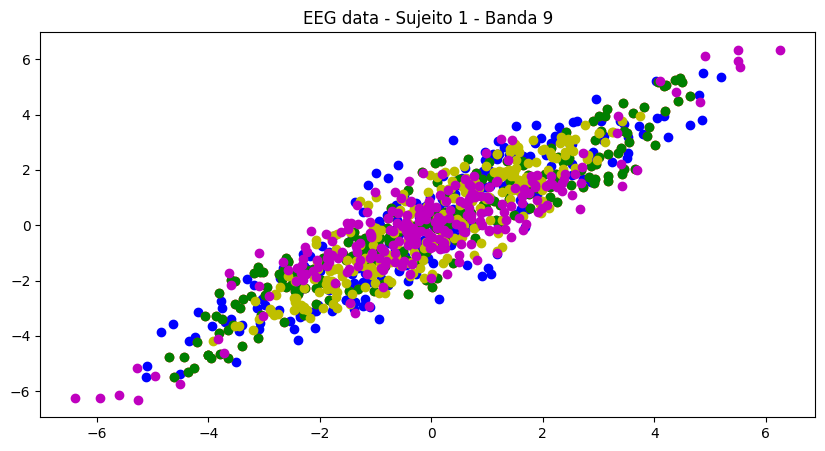

Banda:  10


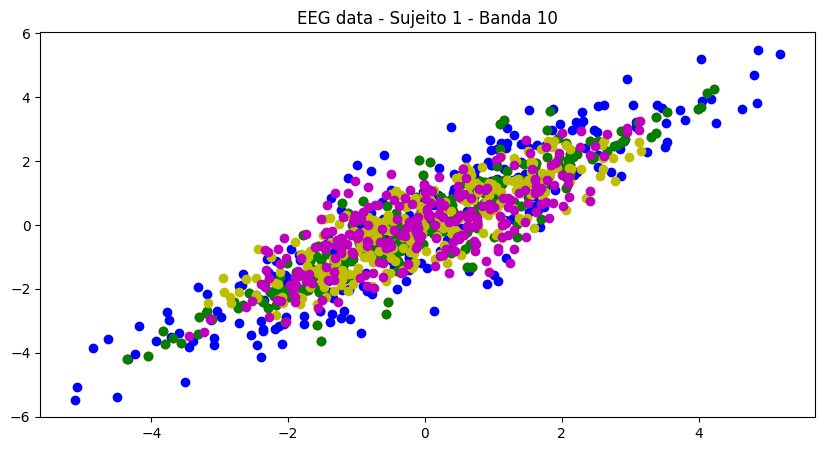

Banda:  11


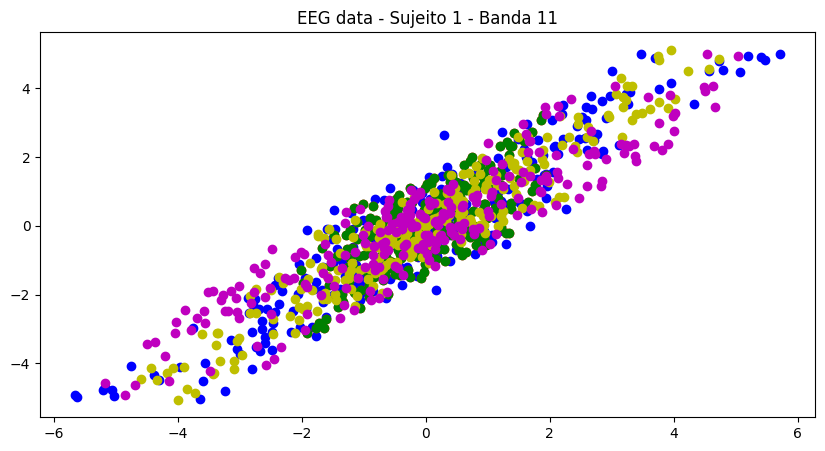

Banda:  12


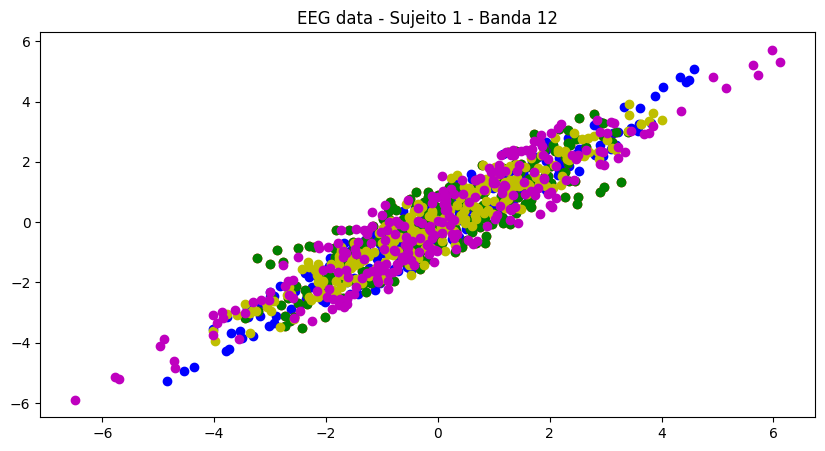

Banda:  13


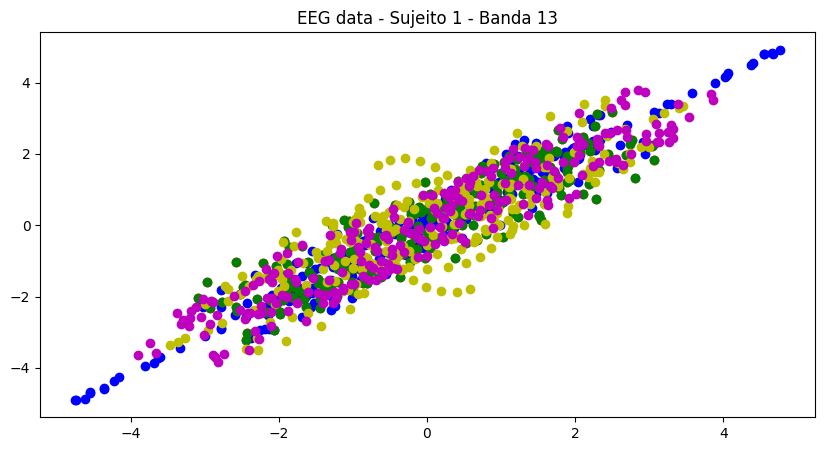

Banda:  14


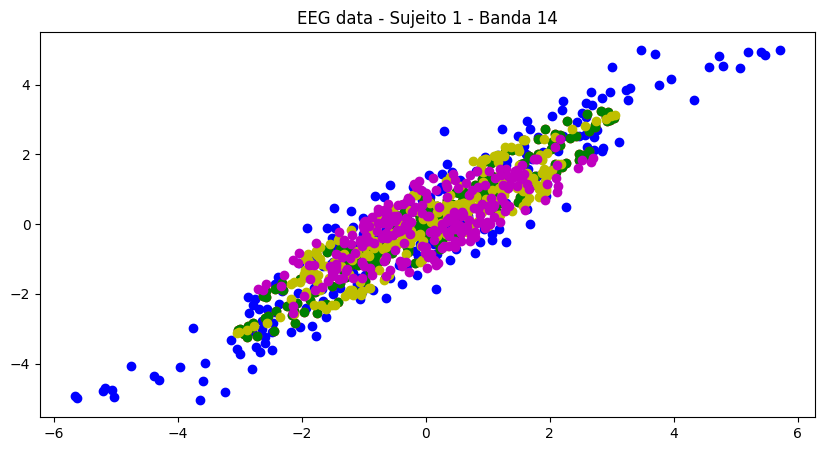

Banda:  15


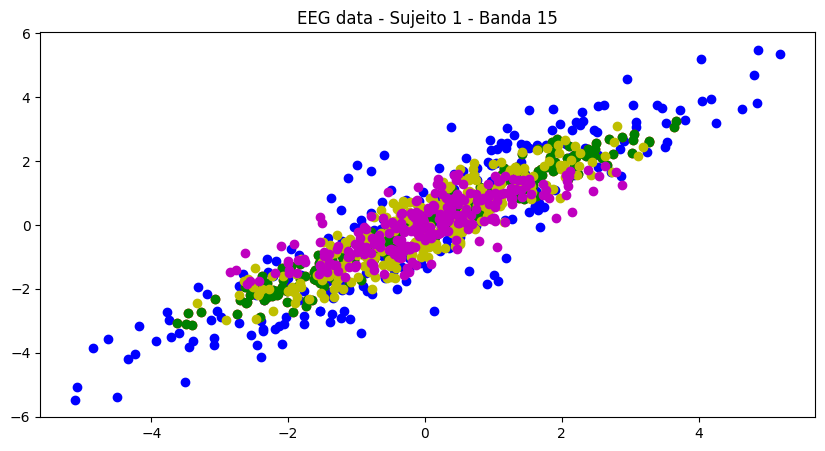

Banda:  16


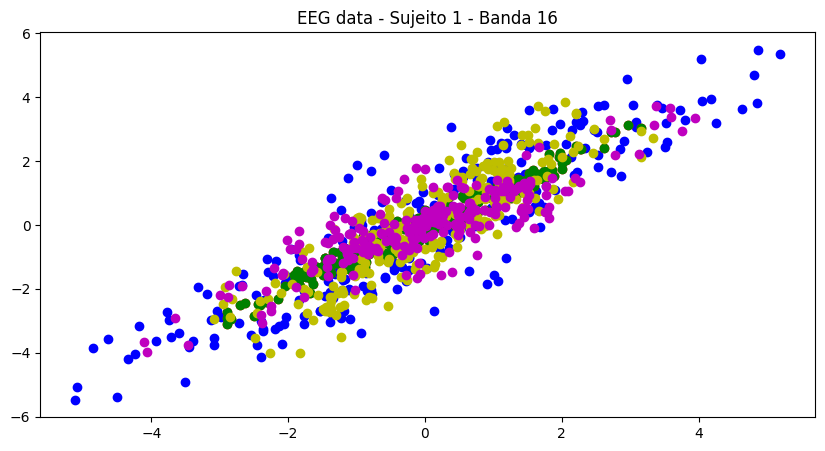

Banda:  17


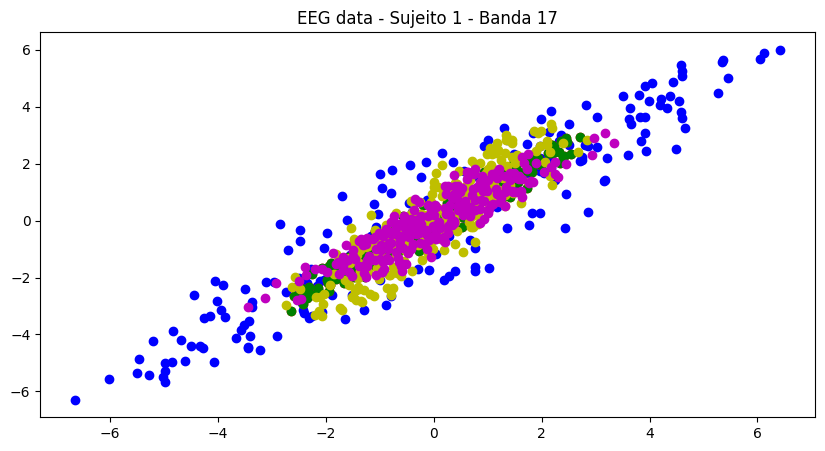

In [ ]:
import matplotlib.pyplot as plt
colors = ['b', 'r', 'g', 'y', 'm']

subject = 0
bands = [[4,8], [6,10], [8, 12], [10, 14], [12, 16], [14, 18], [16, 20], [18, 22], [20, 24], [22, 26], [24, 28], [26, 30], [28, 32], [30, 34], [32, 36], [34, 38], [36, 40]]
print("Sujeito: ", subject+1)

for band in range(len(bands)):
    print("Banda: ", band+1)
    plt.figure(figsize=(10, 5))
    for class_ in range(5):
        # for i in range(all_train_data[subject][band][0][0].shape[0]): 
        #     plt.plot(all_train_data[subject][band][0][0][i])
        plt.scatter(all_train_data[subject][band][class_][0][0], all_train_data[subject][band][class_][0][2], color = colors[class_])
    plt.title(f"EEG data - Sujeito {subject+1} - Banda {band+1}")
    plt.show()



In [ ]:
def train_CSP(X, Y, num_filters):
    X -= np.mean(X, axis=2)[:, :, np.newaxis]

    num_classes = len(np.unique(Y))

    covariances = []
    for i in range(num_classes):
        X_class = X[Y == i]
        S_class = np.mean([np.matmul(X_class[j], X_class[j].T) for j in range(X_class.shape[0])], axis=0)
        covariances.append(S_class)

    S0 = covariances[0]
    S1 = covariances[1]

    d, V = la.eigh(S0, S0 + S1)

    # get order of eigenvalues
    idx = np.argsort(np.abs(d - 0.5))[::-1]

    # reorder the eigenvectors
    V = V[:, idx]

    # transpose
    W = V.T

    # compute the patterns
    pattern = np.linalg.pinv(V)

    #select the two most important filters
    W = W[: num_filters]

    return W


def apply_csp(X, W, mean_power=False):
    X_csp = np.asarray([np.dot(W, epoch) for epoch in X])
    if mean_power:
        X_csp = (X_csp**2).mean(axis=2)
    
    return X_csp

In [ ]:
X = all_train_data[0]

Y = np.array([0]*30 + [1]*30 + [2]*30 + [3]*30 + [4]*30)

print(X.shape)

#apply CSP
W = train_CSP(X, Y, 2)

In [ ]:
def get_filters(X_input, y, J=6):
    filters = []

    for chosen_band in range(len(bands)):
        band_filters = []
        for chosen_class in range(5):
            X = X_input[chosen_band]
            X = X.reshape(-1, X.shape[2], X.shape[3])

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

            y_train = (y_train == chosen_class).astype(int)
            y_test = (y_test == chosen_class).astype(int)

            W = train_CSP(X_train, y_train, J)

            band_filters.append(W)
        filters.append(band_filters)

    return filters

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans

def get_top_bands(X, filters, n_top_bands):
    all_class_filters = []

    for chosen_class in range(5):
        all_filters = []

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
        X_test = X_test.transpose(1, 0, 2, 3)

        X_train = X_train.transpose(1, 2, 3, 0)
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2] * X_train.shape[3])

        for band in range(len(bands)):
            for filter in range(len(filters[band])):
                X_csp = X_train[band]
                X_csp = apply_csp(X_train[band], filters[filter][chosen_class])
                all_filters.append(X_csp[0])

        all_filters = np.array(all_filters)
        all_filters = all_filters.transpose(0, 2, 1).reshape(all_filters.shape[0], all_filters.shape[2] * all_filters.shape[1])
        clustering = AffinityPropagation(random_state = 5).fit(all_filters)
        #clustering = KMeans(n_clusters=8, random_state=0).fit(all_filters)
        #print(chosen_class, "LEN", len(clustering.cluster_centers_))

        # Ele escolheu os centros (que fazem parte do all_filters que lhe demos), agora  é preciso identificar qual é qual 

        selected_filters = []
        for center in clustering.cluster_centers_:
            min_dist = float('inf')
            selected_filter = 0
            for i, filter in enumerate(all_filters):
                dist = np.linalg.norm(center - filter)
                if dist < min_dist:
                    min_dist = dist
                    selected_filter = i
            selected_filters.append(selected_filter)

        selected_filters = [[(f//len(filters[band])), (f%len(filters[band]))] for f in selected_filters]
        selected_filters = np.array(selected_filters)
        all_class_filters.append(selected_filters)

    band_counters = np.zeros((len(bands), 5))

    for class_ in range(5):
        for band, filter in all_class_filters[class_]:
            band_counters[band, class_] += 1

    band_counters_ranked = np.sum(band_counters, axis=1)

    # plt.plot(band_counters_ranked)
    # plt.show()

    return np.argsort(band_counters_ranked)[::-1][:n_top_bands]

The bands and number of features were chosen based on the bands that resulted in less redundant information. These were determined using Affinity Propagation and K_means.

After experimenting, we concluded that band 5 was crucial, and bands 9,12,13,14 were very important, but somewhat redundant among themselves.

After trying various classifiers, we came to the conclusion that the best was the Support Vector Machine with "poly" kernel. Although some Multi-Layered Perceptron architectures achieved simmalar results, these were always in a simmilar same range as the Support Vector Machine, never better. The SVM is a simpler model and as such is prefered, when the accuracy is the same.

In [ ]:
def train_classifier(X, y, chosen_bands, J):
    kernel_type = ["rbf", "linear", "poly", "sigmoid"]
    models = []
    input_signal = []
    score_list = []
    filter_banks = []
    

    for band in chosen_bands:
        signal = X[:, band, :, :]

        #trian test split
        X_train, X_test, y_train, y_test = train_test_split(signal, y, test_size=0.3, random_state=42) #best split so far is  0.3


        W_bank = []
        for i in range(5):
            W = train_CSP(X_train, 1.*(y_train==i), J)
            W_bank.append(W)
        filter_banks.append(W_bank)
        

        for W in W_bank:
            X_csp = apply_csp(X_test, W)
            power = np.log(np.std(X_csp, axis=2))
            # power = np.std(X_csp, axis=2)
            input_signal.append(power)


    input_signal = np.array(input_signal)
    input_signal = input_signal.transpose(1, 0, 2)
    input_signal = input_signal.reshape(input_signal.shape[0], input_signal.shape[1]*input_signal.shape[2])


    #train lda
    for k in kernel_type:
        clf = SVC(kernel=k)
        print("\n\n", k)
        scores = cross_val_score(clf, input_signal, y_test, cv=2, scoring='balanced_accuracy')
        print(scores)
        print("mean", np.mean(scores))
        #print("std", np.std(scores))
        score_list.append(np.mean(scores))
        clf.fit(input_signal, y_test)
        models.append(clf)

    best_kernel = kernel_type[np.argmax(score_list)]
    print("Best kernel: ", best_kernel)

    final_model = SVC(kernel=best_kernel)
    final_model.fit(input_signal, y_test)

    return models[np.argmax(score_list)], filter_banks, np.max(score_list)
    
def preprocess(X, chosen_bands, filter_banks):
    input_signal = []


    for idx, band in enumerate(chosen_bands):
        signal = X[:, band, :, :]

        for W in filter_banks[idx]:
            X_csp = apply_csp(signal, W)
            power = np.log(np.std(X_csp, axis=2))
            # power = np.std(X_csp, axis=2)
            input_signal.append(power)


    input_signal = np.array(input_signal)
    input_signal = input_signal.transpose(1, 0, 2)
    input_signal = input_signal.reshape(input_signal.shape[0], input_signal.shape[1]*input_signal.shape[2])

    return input_signal


def classify(X_processed, model):
    return model.predict(X_processed)

def inference(X, chosen_bands, filter_banks, model):
    X_processed = preprocess(X, chosen_bands, filter_banks)
    return classify(X_processed, model)


mean_values_over_all_subjects = []

for subject in range(len(all_train_data)):
    X = np.array(all_train_data[subject])
    y = np.zeros(X.shape[1]* X.shape[2])
    for class_ in range(X.shape[1]):
        y[class_ * X.shape[2]: (class_ + 1) * X.shape[2]] = class_

    filters = get_filters(X, y)

    X = X.transpose(1, 2, 0, 3, 4)
    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4])

    n_features = 4
    J = 6

    chosen_bands = get_top_bands(X, filters, n_features)

    print("Chosen Bands:", chosen_bands)

    model, filter_banks, validation_acc = train_classifier(X, y, chosen_bands, J)

    #test with X and y
    X_test = np.array(all_test_data[subject])
    X_test = X_test.transpose(1, 2, 0, 3, 4)
    X_test = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2], X_test.shape[3], X_test.shape[4])

    y_test = np.zeros(X_test.shape[0])
    for i in range(5):
        y_test[i*X_test.shape[0]//5:(i+1)*X_test.shape[0]//5] = i

    print("Shapes: ", X_test.shape, y_test.shape)

    print(X_test.shape, y_test.shape)

    y_pred = inference(X_test, chosen_bands, filter_banks, model)
    print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

    mean_values_over_all_subjects.append([balanced_accuracy_score(y_test, y_pred), validation_acc])

mean_values_over_all_subjects = np.array(mean_values_over_all_subjects)

f:\OneDrive\Ambiente de Trabalho\neuro\eegaming\env\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
f:\OneDrive\Ambiente de Trabalho\neuro\eegaming\env\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Chosen Bands: [9 2 0]


 rbf
[0.72136223 0.75111111]
mean 0.7362366701066392


 linear
[0.69793086 0.72627451]
mean 0.7121026831785346


 poly
[0.69793086 0.7269281 ]
mean 0.7124294805641554


 sigmoid
[0.2 0.2]
mean 0.2
Best kernel:  rbf
Shapes:  (150, 17, 16, 250) (150,)
(150, 17, 16, 250) (150,)
Balanced accuracy:  0.76


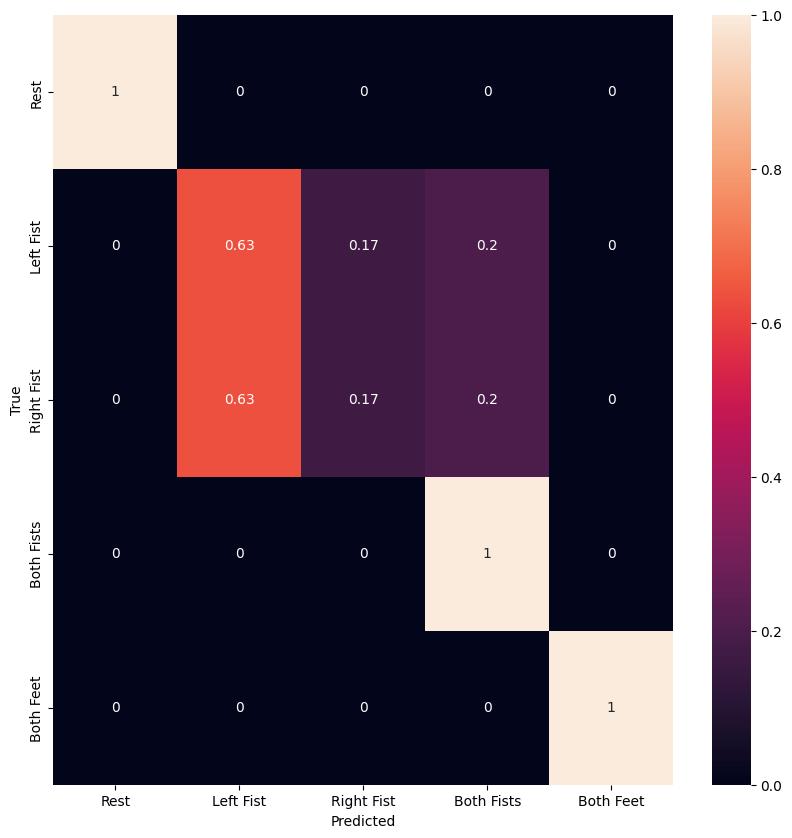

Mean values over all subjects:  [[0.76       0.73623667]]
Mean:  [0.76       0.73623667]
Std:  [0. 0.]


In [ ]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred, ['Rest', 'Left Fist', 'Right Fist', 'Both Fists', 'Both Feet'])

print("Mean values over all subjects: ", mean_values_over_all_subjects)
print("Mean: ", np.mean(mean_values_over_all_subjects, axis=0))
print("Std: ", np.std(mean_values_over_all_subjects, axis=0))



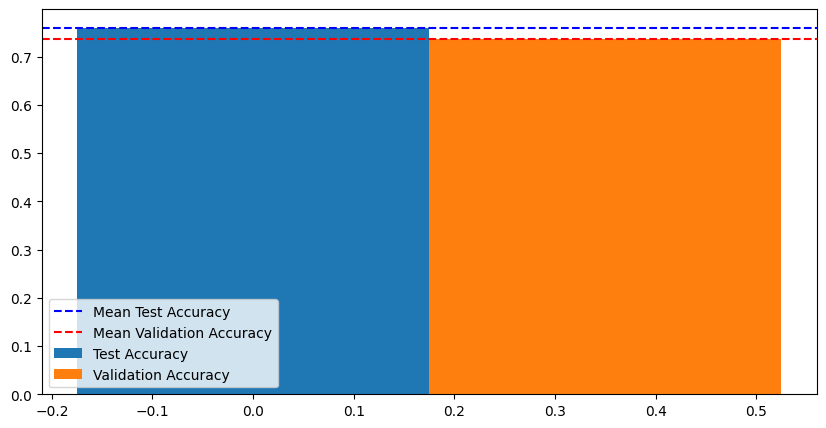

Mean Test Accuracy:  0.76
Mean Validation Accuracy:  0.7362366701066392


<Figure size 1000x500 with 0 Axes>

In [ ]:
bar_width = 0.35
index = np.arange(len(mean_values_over_all_subjects))

plt.figure(figsize=(10, 5))
plt.bar(index, mean_values_over_all_subjects[:, 0], bar_width)
plt.bar(index + bar_width, mean_values_over_all_subjects[:, 1], bar_width)
plt.axhline(y=np.mean(mean_values_over_all_subjects[:, 0]), color='b', linestyle='--')
plt.axhline(y=np.mean(mean_values_over_all_subjects[:, 1]), color='r', linestyle='--')
plt.legend(["Mean Test Accuracy", "Mean Validation Accuracy", "Test Accuracy", "Validation Accuracy"])
plt.show()

print("Mean Test Accuracy: ", np.mean(mean_values_over_all_subjects[:, 0]))
print("Mean Validation Accuracy: ", np.mean(mean_values_over_all_subjects[:, 1]))

plt.figure(figsize=(10, 5))
plt.show()

In [ ]:
print(mean_values_over_all_subjects)

[[0.76       0.73623667]]
